In [21]:
import numpy as np
import pandas as pd
import matplotlib as mp
import statsmodels.api as sm
from scipy import stats

from statsmodels.sandbox.regression.gmm import IV2SLS 
# There is a package named IV2SLS in Python. Do not use this package! The exogenous explanatory variables must
# be entered as instruments. So it gives wrong answers
from statsmodels.sandbox.regression.gmm import GMM

# PART 1

1. Update the GMM model that we discussed in class by incorporating the δ term to the instrumental-variable moment expressions.

In [16]:
# Load the data
input_table = pd.read_csv('https://raw.githubusercontent.com/mn42899/predictive_modelling/refs/heads/main/midterm_partone.csv')
input_table

,Constant,Stock Change,Inventory Turnover,Operating Profit,Interaction Effect,Current Ratio,Quick Ratio,Debt Asset Ratio
0,1,0.870332,1.795946,0.115846,0.208053,1.672527,0.255171,0.473317
1,1,-0.047347,1.395501,0.436967,0.609788,1.637261,0.221763,0.489967
2,1,0.001176,1.664563,0.541016,0.900555,1.640619,0.189141,0.374269
3,1,-0.901200,1.605738,0.539399,0.866133,1.436221,0.131944,0.224399
4,1,-0.176353,1.591451,0.539938,0.859285,1.433140,0.183095,0.213446
...,...,...,...,...,...,...,...,...
1691,1,-0.015543,5.225766,0.309119,1.615384,3.554503,2.197871,0.005549
1692,1,0.399089,5.324390,0.274782,1.463044,3.745006,2.324502,0.004359
1693,1,-0.702200,5.575258,0.287503,1.602905,3.434909,2.282626,0.000000
1694,1,0.283926,5.423463,0.256657,1.391968,2.876645,1.454948,0.000000


In [18]:
# original model
y_vals = np.array(input_table["Stock Change"])
x_vals = np.array(input_table[["Inventory Turnover", "Operating Profit", "Interaction Effect"]])
iv_vals = np.array(input_table[["Current Ratio", "Quick Ratio", "Debt Asset Ratio"]])
n_obs = len(y_vals)

class og_gmm(GMM):
    def momcond(self, params):
        p0, p1, p2, p3 = params
        endog = self.endog
        exog = self.exog
        inst = self.instrument   

        error0 = endog - p0 - p1 * exog[:,0] - p2 * exog[:,1] - p3 * exog[:,2]
        error1 = (endog - p0 - p1 * exog[:,0] - p2 * exog[:,1] - p3 * exog[:,2]) * exog[:,1]
        error2 = (endog - p0 - p1 * exog[:,0] - p2 * exog[:,1] - p3 * exog[:,2]) * exog[:,2]
        error3 = (endog - p0 - p1 * exog[:,0] - p2 * exog[:,1] - p3 * exog[:,2]) * inst[:,0] 
        error4 = (endog - p0 - p1 * exog[:,0] - p2 * exog[:,1] - p3 * exog[:,2]) * inst[:,1] 
        error5 = (endog - p0 - p1 * exog[:,0] - p2 * exog[:,1] - p3 * exog[:,2]) * inst[:,2] 

        g = np.column_stack((error0, error1, error2, error3, error4, error5))
        return g


beta0 = np.array([0.1, 0.1, 0.1, 0.1])
res = og_gmm(endog = y_vals, exog = x_vals, instrument = iv_vals, k_moms=6, k_params=4).fit(beta0)

res.summary()

Optimization terminated successfully.
         Current function value: 0.000046
         Iterations: 8
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 0.000373
         Iterations: 7
         Function evaluations: 13
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 0.000372
         Iterations: 5
         Function evaluations: 9
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 0.000372
         Iterations: 5
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 0.000372
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1


<class 'statsmodels.iolib.summary.Summary'>
"""
                                og_gmm Results                                
==============================================================================
Dep. Variable:                      y   Hansen J:                       0.6317
Model:                         og_gmm   Prob (Hansen J):                 0.729
Method:                           GMM                                         
Date:                Wed, 06 Nov 2024                                         
Time:                        18:08:48                                         
No. Observations:                1696                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p 0           -0.0200      0.021     -0.964      0.335      -0.061       0.021
p 1            0.0011      0.001      1.843      0.065   -6.89e-05       0.002
p 2           -0.1071      0.032     -3.370      0.001      -0.169      -0.045
p 3            0.0011      0.000      2.760      0.006       0.000       0.002
==============================================================================
"""

In [23]:
def print_gmm_results(results, n_obs, title):
    """

    """
    print("=" * 50)
    print(title)
    print("=" * 50)
    print("Dep. Variable:           y")
    print(f"No. Observations:       {n_obs}")
    print(f"Hansen J:               {results.jtest}")
    print("\nParameters:")
    print("-" * 50)
    print(f"{'Parameter':<12}{'Coef':<10}{'Std Err':<10}{'z':<10}{'P>|z|':<10}")
    print("-" * 50)
    
    std_errors = np.sqrt(np.diag(results.cov_params()))
    
    param_names = ['Constant', 'Inv Turn', 'Op Profit', 'Inter Eff']
    
    for i, (name, coef, std_err) in enumerate(zip(param_names, results.params, std_errors)):
        z_stat = coef / std_err
        p_val = 2 * (1 - stats.norm.cdf(abs(z_stat)))
        print(f"{name:<12}{coef:<10.4f}{std_err:<10.4f}{z_stat:<10.4f}{p_val:<10.4f}")
    
    print("\n")

In [24]:
# Modified GMM class with scalar delta
class updated_gmm(GMM):
    def momcond(self, params):
        p0, p1, p2, p3 = params
        endog = self.endog
        exog = self.exog
        inst = self.instrument
        
        # Scalar delta
        delta = 1.0
        
        error = endog - p0 - p1 * exog[:,0] - p2 * exog[:,1] - p3 * exog[:,2]
        
        error0 = error - delta
        error1 = error * exog[:,1] - delta
        error2 = error * exog[:,2] - delta
        error3 = error * inst[:,0] - delta
        error4 = error * inst[:,1] - delta
        error5 = error * inst[:,2] - delta

        g = np.column_stack((error0, error1, error2, error3, error4, error5))
        return g

# Estimate models
original_model = og_gmm(endog=y_vals, exog=x_vals, instrument=iv_vals, k_moms=6, k_params=4)
updated_model = updated_gmm(endog=y_vals, exog=x_vals, instrument=iv_vals, k_moms=6, k_params=4)

original_results = original_model.fit(beta0)
updated_results = updated_model.fit(beta0)

# Print results
print_gmm_results(original_results, n_obs, "Original GMM Results")
print_gmm_results(updated_results, n_obs, "Updated GMM Results (with δ=1)")

# Print comparison
print("Parameter Comparison:")
print("=" * 50)
comparison = pd.DataFrame({
    'Original GMM': original_results.params,
    'Modified GMM': updated_results.params,
    'Difference': updated_results.params - original_results.params
}, index=['Constant', 'Inventory Turnover', 'Operating Profit', 'Interaction Effect'])
print(comparison.round(4))


Optimization terminated successfully.
         Current function value: 0.000046
         Iterations: 8
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 0.000373
         Iterations: 7
         Function evaluations: 13
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 0.000372
         Iterations: 5
         Function evaluations: 9
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 0.000372
         Iterations: 5
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 0.000372
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.549867
         Iterations: 8
         Function evaluations: 12
         Gra

# PART 2

1.	Divide the dataset equally into two as training (50%) and test (50%) sets. Use the training set to fit a logistic regression model, where the credit rating is the dependent variable. Apply the model to the test set, and report the confusion matrix, recall, precision, and F1 score values.

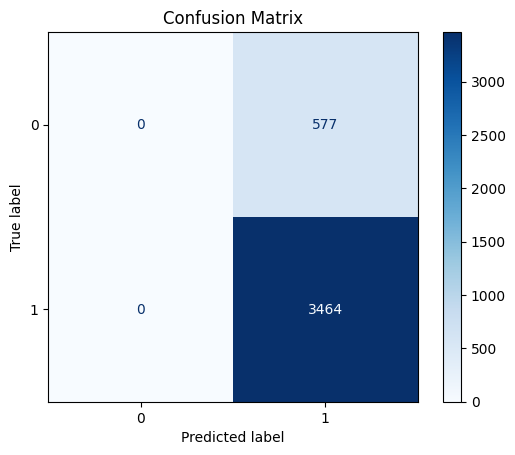

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       577
           1       0.86      1.00      0.92      3464

    accuracy                           0.86      4041
   macro avg       0.43      0.50      0.46      4041
weighted avg       0.73      0.86      0.79      4041



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

In [27]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load the dataset
url = 'https://raw.githubusercontent.com/mn42899/predictive_modelling/refs/heads/main/midterm_parttwo.csv'
data = pd.read_csv(url)

# Convert categorical variables to numerical (if needed)
data['Credit Rating'] = data['Credit Rating'].apply(lambda x: 1 if x == 'Positive' else 0)

# Define features and target variable
X = pd.get_dummies(data.drop('Credit Rating', axis=1), drop_first=True)
y = data['Credit Rating']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Train logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate and display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# Print the classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

2. Suppose that the bank decided to make the credit approval process more challenging such that only 15% of the applications would be granted. Calculate the threshold value for the prediction probability, so only 15% of the test set would get their applications approved. Then, update your confusion matrix, recall, precision, and F1 scores. 

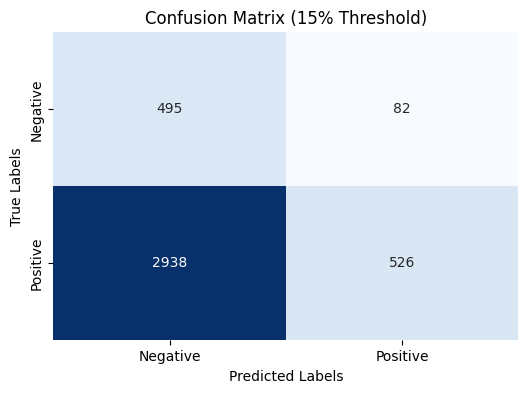

Classification Report with 15% Threshold:

              precision    recall  f1-score   support

           0       0.14      0.86      0.25       577
           1       0.87      0.15      0.26      3464

    accuracy                           0.25      4041
   macro avg       0.50      0.50      0.25      4041
weighted avg       0.76      0.25      0.26      4041


Metrics with 15% Threshold:
Precision: 0.8651315789473685
Recall: 0.15184757505773672
F1 Score: 0.2583497053045187


In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report

# Predict probabilities instead of labels
y_proba = model.predict_proba(X_test)[:, 1]

# Calculate threshold to classify only 15% as approved
threshold = np.percentile(y_proba, 85)

# Predict with the new threshold
y_pred_new = (y_proba >= threshold).astype(int)

# Calculate metrics with the new threshold
conf_matrix_new = confusion_matrix(y_test, y_pred_new)
precision_new = precision_score(y_test, y_pred_new)
recall_new = recall_score(y_test, y_pred_new)
f1_new = f1_score(y_test, y_pred_new)

# Display Confusion Matrix using Seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_new, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix (15% Threshold)")
plt.show()

# Display Classification Report
print("Classification Report with 15% Threshold:\n")
print(classification_report(y_test, y_pred_new))

# Also store the results in variables if needed
print("\nMetrics with 15% Threshold:")
print("Precision:", precision_new)
print("Recall:", recall_new)
print("F1 Score:", f1_new)